In [1]:
%run setup.py

In [2]:
stars = pd.read_excel(rootpath+'surface/sample/samples.xlsx')
idx =  (stars['ifmodelling']==1) & np.isin(stars['names'], ['ngc6791', 'ngc6819']) #& (stars['ruwe']<1.2)

stars = stars.loc[idx,:].reset_index(drop=True)
       
idx = ~np.isfinite(stars['Dnu'])
stars.loc[idx, 'Dnu'] = stars.loc[idx, 'Dnu_guess']

In [3]:
idx1 = np.isin(stars['names'], ['ngc6791']) & (stars['ruwe']<1.2) & (stars['e_lum_J']/stars['lum_J'] < 0.25)#ngc6
idx2 = np.isin(stars['names'], ['ngc6819']) & (stars['ruwe']<1.2) & (stars['e_lum_J']/stars['lum_J'] < 0.25)#ngc6


def multi(inputs):
    istar, star = inputs
    cols = ['chi2', 'star_age']
    
    filepath1 = rootpath+'surface/results_spec_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    filepath2 = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not (os.path.exists(filepath1) & os.path.exists(filepath2)): return [None, None]
    data = h5py.File(filepath1, 'r')
    chi2_b, age_b = [data[col][:] for col in cols]
    prob_b = np.exp(-chi2_b/2.)
    
    data = h5py.File(filepath2, 'r')
    chi2_a, age_a = [data[col][:] for col in cols]
    prob_a = np.exp(-chi2_a/2.)
    
    return [[prob_b, prob_a], [age_b, age_a]]

r = process_map(multi, stars.loc[idx1,:].iterrows(), total=np.sum(idx1), max_workers=12)
probs1, ages1 = [i[0] for i in r if i is not None], [i[1] for i in r if i is not None]

def multi(inputs):
    istar, star = inputs
    cols = ['chi2', 'star_age']
    
    filepath1 = rootpath+'surface/results_spec_gaia_nu/{:0.0f}/data.h5'.format(star['KIC'])
    filepath2 = rootpath+'surface/results_spec_gaia_nu_sc/{:0.0f}/data.h5'.format(star['KIC'])
    if not (os.path.exists(filepath1) & os.path.exists(filepath2)): return [None, None]
    data = h5py.File(filepath1, 'r')
    chi2_b, age_b = [data[col][:] for col in cols]
    prob_b = np.exp(-chi2_b/2.)
    
    data = h5py.File(filepath2, 'r')
    chi2_a, age_a = [data[col][:] for col in cols]
    prob_a = np.exp(-chi2_a/2.)
  
    return [[prob_b, prob_a], [age_b, age_a]]
r = process_map(multi, stars.loc[idx2,:].iterrows(), total=np.sum(idx2), max_workers=12)
probs2, ages2 = [i[0] for i in r if i is not None], [i[1] for i in r if i is not None]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

In [4]:
Nstar1, Nstar2 = len(probs1), len(probs2)
t1 = np.linspace(0,20e9,100)
t2 = np.linspace(0,5e9,100)
prob_tb1 = [np.zeros(len(t1)) for i in range(Nstar1)]
prob_ta1 = [np.zeros(len(t1)) for i in range(Nstar1)]
prob_tb2 = [np.zeros(len(t2)) for i in range(Nstar2)]
prob_ta2 = [np.zeros(len(t2)) for i in range(Nstar2)]

In [5]:
from sklearn.neighbors import KernelDensity

for istar in tqdm(range(Nstar1)):
    idx = (probs1[istar][0]>0)
    kde = KernelDensity(kernel='gaussian', bandwidth=1.2e9).fit(ages1[istar][0][idx][:,None], None, probs1[istar][0][idx])
    prob_tb1[istar] = np.exp(kde.score_samples(t1[:, None]))
    
    idx = (probs1[istar][1]>0)
    kde = KernelDensity(kernel='gaussian', bandwidth=1.2e9).fit(ages1[istar][1][idx][:,None], None, probs1[istar][1][idx])
    prob_ta1[istar] = np.exp(kde.score_samples(t1[:, None]))

100%|██████████| 20/20 [00:12<00:00,  1.61it/s]


In [6]:
for istar in tqdm(range(Nstar2)):
    idx = (probs2[istar][0]>0)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2e9).fit(ages2[istar][0][idx][:,None], None, probs2[istar][0][idx])
    prob_tb2[istar] = np.exp(kde.score_samples(t2[:, None]))
    
    idx = (probs2[istar][1]>0)
    kde = KernelDensity(kernel='gaussian', bandwidth=0.2e9).fit(ages2[istar][1][idx][:,None], None, probs2[istar][1][idx])
    prob_ta2[istar] = np.exp(kde.score_samples(t2[:, None]))

100%|██████████| 18/18 [00:06<00:00,  2.85it/s]


In [7]:
# rms improvement
Nstars = len(prob_tb1)
ages_b1, ages_a1 = np.zeros(Nstars), np.zeros(Nstars)
for i in range(Nstars):
    ages_b1[i] = np.sum(prob_tb1[i]*t1/np.sum(prob_tb1[i]))/1e9
    ages_a1[i] = np.sum(prob_ta1[i]*t1/np.sum(prob_ta1[i]))/1e9
np.std(ages_b1), np.std(ages_a1)

(2.1126607209685946, 0.9832317746641447)

In [8]:
# rms improvement
Nstars = len(prob_tb2)
ages_b2, ages_a2 = np.zeros(Nstars), np.zeros(Nstars)
for i in range(Nstars):
    ages_b2[i] = np.sum(prob_tb2[i]*t2/np.sum(prob_tb2[i]))/1e9
    ages_a2[i] = np.sum(prob_ta2[i]*t2/np.sum(prob_ta2[i]))/1e9
np.std(ages_b2), np.std(ages_a2)

(0.45846888423391846, 0.44307486842658356)

Age/Gyr: 7.88
Age/Gyr: 1.72


0

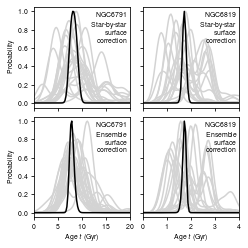

In [9]:
# program
from scipy.optimize import curve_fit

fig, axes = plt.subplots(figsize=mnras_size(ratio=1.,column='one'), nrows=2, ncols=2, 
                         squeeze=False, constrained_layout=True)
# axes = axes.reshape(-1)

joint_prob_tb1 = np.ones(len(t1))
joint_prob_ta1 = np.ones(len(t1))
for istar in range(Nstar1):
    joint_prob_tb1 *= prob_tb1[istar]
    axes[0,0].plot(t1/1e9, prob_tb1[istar]/np.max(prob_tb1), color='lightgray')
    joint_prob_ta1 *= prob_ta1[istar]
    axes[1,0].plot(t1/1e9, prob_ta1[istar]/np.max(prob_ta1), color='lightgray')
print('Age/Gyr: {:.2f}'.format(t1[np.argmax(joint_prob_ta1)]/1e9))

    
joint_prob_tb2 = np.ones(len(t2))
joint_prob_ta2 = np.ones(len(t2))
for istar in range(Nstar2):
    joint_prob_tb2 *= prob_tb2[istar]
    axes[0,1].plot(t2/1e9, prob_tb2[istar]/np.max(prob_tb2), color='lightgray')
    joint_prob_ta2 *= prob_ta2[istar]
    axes[1,1].plot(t2/1e9, prob_ta2[istar]/np.max(prob_ta2), color='lightgray')
print('Age/Gyr: {:.2f}'.format(t2[np.argmax(joint_prob_ta2)]/1e9))

    
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# popt, pcov = curve_fit(gauss_function, t1/1e9, joint_prob_tb1/np.max(joint_prob_tb1), p0=[1., t1[np.argmax(joint_prob_tb1)]/1e9, 0.07])
axes[0,0].plot(t1/1e9, joint_prob_tb1/np.max(joint_prob_tb1), color='k')

# popt, pcov = curve_fit(gauss_function, t1/1e9, joint_prob_ta1/np.max(joint_prob_ta1), p0=[1., t1[np.argmax(joint_prob_ta1)]/1e9, 0.07])
axes[1,0].plot(t1/1e9, joint_prob_ta1/np.max(joint_prob_ta1), color='k')


# popt, pcov = curve_fit(gauss_function, t2/1e9, joint_prob_tb2/np.max(joint_prob_tb2), p0=[1., t2[np.argmax(joint_prob_tb2)]/1e9, 0.07])
axes[0,1].plot(t2/1e9, joint_prob_tb2/np.max(joint_prob_tb2), color='k')

# popt, pcov = curve_fit(gauss_function, t2/1e9, joint_prob_ta2/np.max(joint_prob_ta2), p0=[1., t2[np.argmax(joint_prob_ta2)]/1e9, 0.07])
axes[1,1].plot(t2/1e9, joint_prob_ta2/np.max(joint_prob_ta2), color='k')

for ax in axes[:,0].reshape(-1):
    ax.set_xlim(0,20)
    ax.text(0.97, 0.9, 'NGC6791', transform=ax.transAxes, ha='right')
    ax.set_ylabel('Probability')

for ax in axes[:,1].reshape(-1):
    ax.set_xlim(0,4)
    ax.text(0.97, 0.9, 'NGC6819', transform=ax.transAxes, ha='right')
    ax.set_yticklabels([])
    
for ax in axes[0,:].reshape(-1):
    ax.text(0.97, 0.65, 'Star-by-star\n surface\n correction', transform=ax.transAxes, ha='right', fontsize=fontsize)
    ax.set_xticklabels([])
    
for ax in axes[1,:].reshape(-1):
    ax.text(0.97, 0.65, 'Ensemble\n surface\n correction', transform=ax.transAxes, ha='right', fontsize=fontsize)
    ax.set_xlabel('Age $t$ (Gyr)')


fig.set_constrained_layout_pads(w_pad=0.01, h_pad=0.01, hspace=0, wspace=0)


filename = 'Fig.5_cluster_age.pdf'

plt.savefig(filename)
os.system(to_overleaf(filename, 'figures'))